 #  Will you accept this model? Predicting love on the Bachelorette


# Part 3

## Forward 

This is the final installment of a three part project looking to predict love on ABC's "The Bachelorette.  In [part 1](https://github.com/desdelgado/Predicting_Roses/blob/master/Rose_Data_Engineering_P1.ipynb) and [part 2](https://github.com/desdelgado/Predicting_Roses/blob/master/Rose_Data_Engineering_P2.ipynb), I go over how we built our input dataset from scratch since there wasn't a good dataset online.  Feel free to go back and read those sections, however, I wrote the machine learning part below so it can be read as a standalone as well.  


## Introduction 

Recently, I took a plunge into the bachelorette and #bachelornation to take interest in my girlfriend's hobbies.  One of many things I learned about is the existence of bachelor fantasy where my girlfriend would pick certain contestants every week and get points based on what they did.  One of the more interesting sources of points was picking who was going to make it to the next round.  This got me to thinking if I could possibly encode love within this gameshow and predict who was going to be eliminated when using machine learning.  Not only would this help me learn more about the show, but also help my girlfriend win her work fantasy pool.  

Now armed with a starting dataset built [here](https://github.com/desdelgado/Predicting_Roses/blob/master/Rose_Data_Engineering_P1.ipynb) and [here](https://github.com/desdelgado/Predicting_Roses/blob/master/Rose_Data_Engineering_P2.ipynb), let's see if computers are capable of feeling some love. Let's first import important libraries as well as the constructed dataset

In [1]:
#Important Libraries added as I went through the project
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn import metrics

import seaborn as sns; sns.set()
import time
import numpy as np
from pandas.plotting import scatter_matrix
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

import numpy as np


In [2]:
Bachelorette_Data = pd.read_csv('Bachelorette_Data/Bachelorette_Predict.csv', header = 0 )
Bachelorette_Data = Bachelorette_Data.drop(['Unnamed: 0','SHOW'], axis = 1)
print(Bachelorette_Data.columns)

Index(['CONTESTANT', 'Round_Eliminated', 'First_Impression_Rose',
       'Percentage Left after D1', 'Match Region', 'Match City',
       'Political Difference', 'Age Difference'],
      dtype='object')


Cool, we have are target variable in 'Round_Eliminated' with various feature columns

Normally we would do some exploratory data analysis (EDA), however, we already know from when we constructed the data that there is missing data in the 'Percentage Left after D1' column' corresponding to contestants that never got a one on one date.  We can infill those NaN's with 0s.  

In [3]:
data_in = pd.DataFrame(Bachelorette_Data[Bachelorette_Data.columns[1:]])
print('Null values before: ' +str(data_in['Percentage Left after D1'].isnull().sum()))
data_in['Percentage Left after D1'].fillna(0, inplace = True)
print('Null values After: ' +str(data_in['Percentage Left after D1'].isnull().sum()))

Null values before: 230
Null values After: 0


## Exploratory Data Analysis

Now let's get into the EDA.  We can plot some simple histograms to see the distribution of our data.

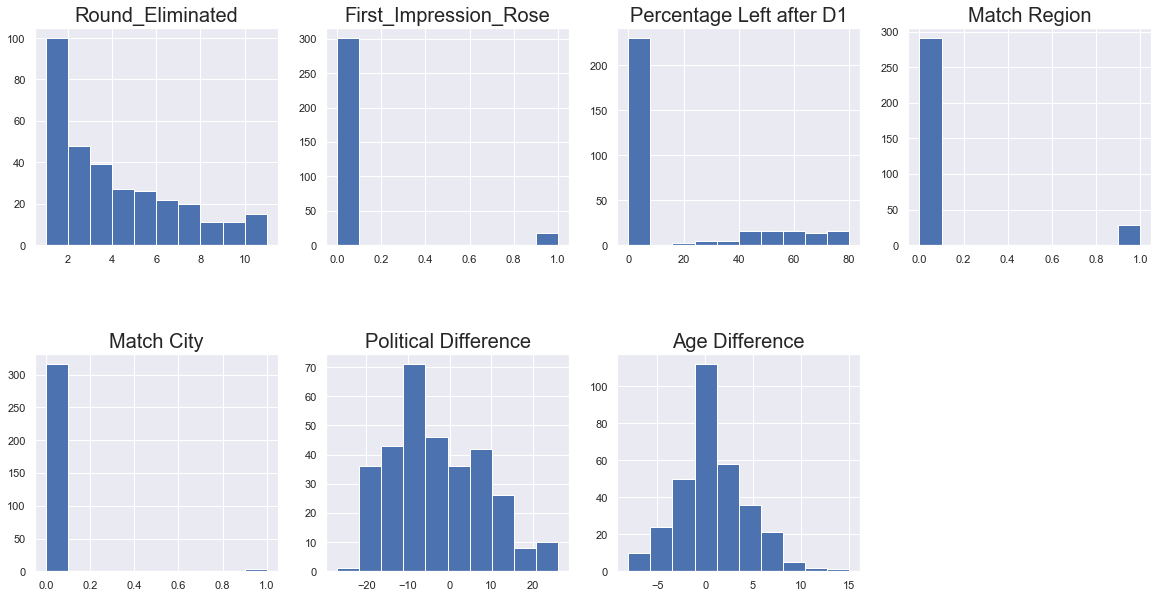

In [4]:
plt.figure(figsize=(20,40), facecolor='white')
plot_number = 1
for column in data_in.columns:
    plt.subplot(7, 4, plot_number)
    plt.subplots_adjust(hspace = 0.5)
    plt.hist(data_in[column], bins = 10)
    plt.title(column, fontsize = 20 )
    #plt.xlabel('Cycle Number', fontsize = 20)
    plot_number += 1
plt.show()

A few things to note here.  First: the majority of the contestants are about the same age as their bachelorettes.  Second: not many contestants are from the same region nor from the same city.  Finally, there seems to be a good amount of political difference.  

Let's extend this EDA by looking at how features are correlated with each other in a correlation matrix.  This matrix gives us a number between 1 and -1 for each pair of features which means if the number is close to 1 they're positivity correlated, close to -1 negatively correlated, and if the number is close to 0 there is no correlation.  Thus, we are hoping that there are some features not close to zero with regards to our target variable of "Round_Eliminated."

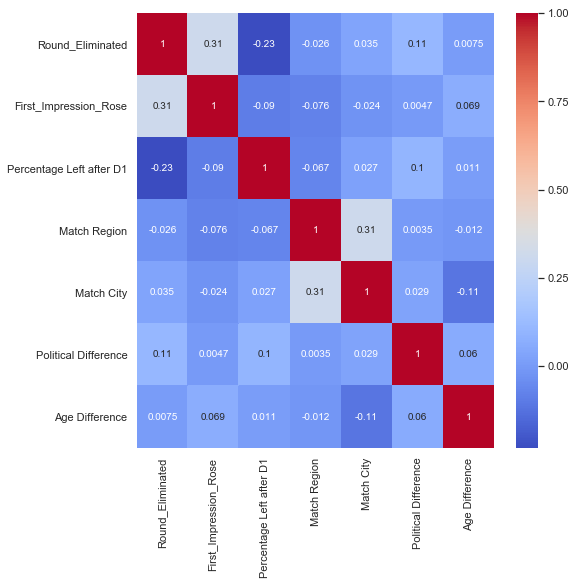

In [17]:
correlations = Bachelorette_Data[Bachelorette_Data.columns[1:]].corr()

plt.figure(figsize=(8, 8))
sns.heatmap(correlations,annot=True, cmap = 'coolwarm')
plt.show()

Dang, when we look at the "Round_Eliminated" either column or row we see that the most positive correlation is the "Political Difference" at 0.11 and the most negative is the "Percentage Left after D1" at -0.23.  On the surface, this data set doesn't look great as we have maybe two variables that are correlated to the target variable.  

All is not lost though as the correlation matrix above only looks at the linear relationship between variables.  We can see if there are non-linear correlation's by looking at the mutual information between variables.  In short, this metric tells us how much information we gain about one variable given knowledge of another.  If the metric is 0 then the variables are independent of each other.  On the other hand, the higher the metric to more dependent they are.  To put it another way, if we know it's sunny out, then we also know there's a low probability that it is raining and we would return a high mutual information score (in our minds).  For further reading, check out this [Wikipedia article](https://en.wikipedia.org/wiki/Mutual_information)  Let's use sklearn's `mutual_information_regression` to see what we can get.

                    Feature  MI_Score
1  Percentage Left after D1  0.417343
0     First_Impression_Rose  0.100201
2              Match Region  0.000000
3                Match City  0.000000
4      Political Difference  0.000000
5            Age Difference  0.000000


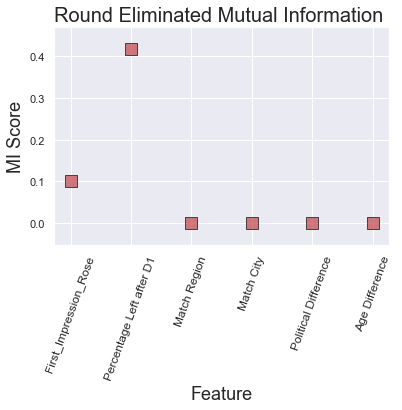

In [6]:
# Get sepearte dataframe 
MI_df = pd.DataFrame(data_in)

# Split the dataframe into our target and feature variables
target = MI_df['Round_Eliminated']
MI_df.drop(['Round_Eliminated'], axis=1, inplace=True)

score = pd.DataFrame()

# Make a column of the features for our outputs
tick_labels = MI_df.columns.get_values().tolist()
score['Feature'] = tick_labels

# Find the mutual information score between each feature and the target variable
score['MI_Score'] = mutual_info_regression(MI_df, target, random_state  = 2)

# Make a nice plot
fig, ax = plt.subplots()
ax.scatter(score.index, score['MI_Score'], marker = 's', s = 150, edgecolors = 'k', lw = 1, alpha = .75, c = 'r')

ax.set_xticks(np.arange(len(tick_labels)))
ax.set_xticklabels(tick_labels, rotation = 70, fontsize = 12)
ax.set_xlabel('Feature', fontsize = 18)
ax.set_ylabel('MI Score', fontsize = 18)
ax.set_title('Round Eliminated Mutual Information ', fontsize = 20);

print(score.sort_values(by = ['MI_Score'], ascending = False))

Alright, we see that most of our features are pretty close to zero.  This trend means that most of these features are close to independent of which round a contestant will be eliminated.  The only outlier is the "Percentage Left after D1" which makes sense as [538's article](https://fivethirtyeight.com/features/the-bachelorette/) also talked about how important getting an early first date is.  Finally, I am most surprised that "Match City" is at the bottom considering the prevailing notion of people falling in love with what is familiar i.e someone from their hometown.  I guess the construct of the show and the magic of L.A. or NYC blanks this trend.  

Going forward, this isn't great news for our model building, as there's not a lot of dependencies between the features and the target.  Let's still run this data through some different models to see what happens.

## Picking a Model

Now that we have a handle on the distribution of our data and how variables are correlated, let's try some modeling to see what some predictions would look like. 

As in good practice, we'll split our data into training and test data in order to avoid getting artificially high accuracy numbers.  

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data_in.iloc[:,1:], data_in["Round_Eliminated"], test_size=0.3, random_state=5)

This is where a bit of art comes in in terms of picking a model.  Normally, I would start with a linear model, however, we already saw in the correlation matrix not a lot of linear dependency between the features and target variable so let's avoid that.  

Taking a step back, when one's on a date typically you go through various decisions about the opposite person: do they like dogs? Do they like certain sports teams? Do they like the bachelorette?  This thought process sounds a lot like a decision tree.  Thus, as a starting point let's investigate a random forest regressor which is an ensemble method utilizing a bunch of decision trees.  Moreover, using the ensemble method will help us avoid overfitting our data.  Furthermore, we can use cross-fold validation to further insulate our model from over fitting.

In [8]:
reg = RandomForestRegressor()

#Ignore depreciation warnings
warnings.filterwarnings("ignore")
kfold = KFold(n_splits=3, random_state=5)
cv_results = cross_val_score(reg, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
RMSE_CV_results = ((abs(cv_results))**0.5).mean()
print('RMSE Score of: ' + str(RMSE_CV_results))

RMSE Score of: 1.9449419087111488


Having a RMSE score of ~2 means that if our model predicts a contestant will be eliminated in round 5, it is reasonable to expect that they could be eliminated in anywhere between round 3 and round 7.  Since a typical show is around 10 episodes this isn't a fantastic model to use but is a start.  Perhaps we can better tell if our contestants made it to the later rounds or not.  For example, predicting a contestant will be eliminated in round 2 means my girlfriend should most likely leave them out of her picks for the first few weeks.  On the flip side if a contestant is predicted to be eliminated in round 8, she should probably pick them in the early rounds.  Our goal moving forward would be to reduce this RMSE score as much as possible, so we can get a smaller window to predict elimination.  

Now that our initial model is alright but not the best, let's reuse a function from a previous regression project I worked on.  In that project, I attempted to predict engine failure using signal data and can be found [here](https://github.com/desdelgado/Turbofan_Project/blob/master/Turbo_Fan_Failure_Prediction.ipynb).  There, I wrote a function that looks at various models and quickly checks them against each other.  This can help guide our choice of model moving forward. 

In [9]:
def compare_algorithms(algorithms, X_data, y_data, scoring = 'neg_mean_squared_error', num_folds = 3, seed = 5):
    '''
        Intake: list of (names: algorithms) to compare scoring metric and run time using cross fold validation. 
        Returns: Data frame with a summary of the data and the MSE for each fold of each technique.
    '''
    #This line for ignoring the warnings talking about how certain features will be depreciated in the future.
    warnings.filterwarnings("ignore")
    results = []
    names = []
    times = []
    results_mean =[]
    results_std = []
    for name, model in algorithms:
        kfold = KFold(n_splits=num_folds, random_state=seed)
        start = time.time()
        cv_results = cross_val_score(model, X_data, y_data, cv=kfold, scoring='neg_mean_squared_error')
        RMSE_CV_results = (abs(cv_results))**0.5
        results.append(RMSE_CV_results)
        results_mean.append(RMSE_CV_results.mean())
        results_std.append(RMSE_CV_results.std())
        run_time = time.time()-start
        names.append(name)
        times.append(run_time)
        
    algorithms_df = pd.DataFrame(
        {'Names': names,
         'Mean RMSE': results_mean,
         'Std': results_std,
         'Time (s)': times,
        })
    return algorithms_df, results

Next, let's use a couple different regression models including the random forest regressor to help calibrate where we are at.  We can then graph and print the RMSE data to inspect our results.

In [10]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('Bagging', RandomForestRegressor()))

single_model_compare, results = compare_algorithms(models, X_train, y_train, num_folds = 7)

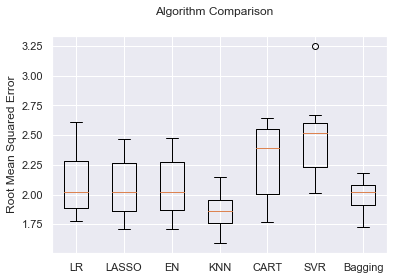

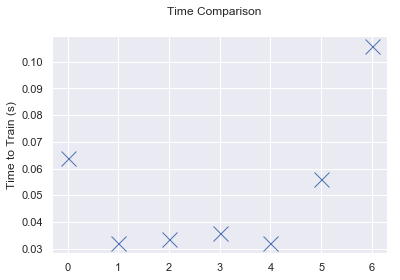

     Names  Mean RMSE       Std  Time (s)
0       LR   2.106248  0.286638  0.063915
1    LASSO   2.063791  0.261663  0.031956
2       EN   2.068575  0.265066  0.033453
3      KNN   1.861420  0.177166  0.035950
4     CART   2.275598  0.322008  0.031956
5      SVR   2.493192  0.377112  0.055925
6  Bagging   1.989288  0.139282  0.105960


In [11]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(single_model_compare['Names'])
ax.set_ylabel('Root Mean Squared Error')
plt.show()    

fig1 = plt.figure()
fig1.suptitle('Time Comparison')
ax1 = fig1.add_subplot(111)
plt.plot(single_model_compare['Time (s)'], 'x', ms = 15)
ax1.set_ylabel('Time to Train (s)')

plt.show()

print(single_model_compare)

From here it looks like timing isn't much of an issue.  It also looks like a K-Nearest Neighbor (KNN) might be the best bet with an average RMSE score of ~2.03.  We can then tune the various parameters that go into a KNN model and see if we can improve upon this base RMSE score.  

## Tuning Our Best Model

Upon looking up the KNN documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) one can see there are six or so parameters to adjust.  Even limiting each to only two options produces far more combinations than we have time to look at.  Instead we can create a grid of each combination of parameters and randomly search that grid.  From there, we can do a finer search of the best random parameters and hopefully get an improved model. 

Let's first do the random search.

In [12]:
#%% Hyperparameter Tune Knn
model = KNeighborsRegressor(n_jobs=-1)
#Hyper Parameters Set
params = {'n_neighbors':[5,6,7, 8,10], # Number of neighbors to look at 
          'leaf_size':[10,20,30,40,50,60],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute'],
          'p':[1,2],
          'n_jobs':[-1]}

model1 = RandomizedSearchCV(estimator = model, param_distributions = params, n_iter = 50,
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)

model1.fit(X_train,y_train)
#The best hyper parameters set
print("Best Hyper Parameters:\n",model1.best_params_)

#Save the parameters so we can use them in the future
estimators_random = model1.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.3s


Best Hyper Parameters:
 {'weights': 'uniform', 'p': 2, 'n_neighbors': 10, 'n_jobs': -1, 'leaf_size': 60, 'algorithm': 'kd_tree'}


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   21.1s finished


Let's write a function that will allow us to quickly check this tuned (though randomly) version of the model against just the basic un-tuned model we tried earlier.  

In [13]:
def evaluate_model(model, test_features, test_labels, model_name = 'General', scoring = 'neg_mean_squared_error', num_folds = 7, seed = 5):
    '''
        Intake: list of (names: algorithms) to compare scoring metric and run time using cross fold validation. 
        Returns: Data frame with a summary of the data and the MSE for each fold of each technique.
    '''
    #This line for ignoring the warnings talking about how certain features will be depreciated in the future.
    warnings.filterwarnings("ignore")
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, test_features, test_labels, cv=kfold, scoring='neg_mean_squared_error')
    RMSE_CV_results = (abs(cv_results))**0.5
    results_mean = RMSE_CV_results.mean()
    results_std = RMSE_CV_results.std()
    
    
    print('Model Performance of '+ model_name)
    print('Root Mean Squared Error: {:0.4f} Rounds, std: {:0.4f}.'.format(results_mean, results_std))

In [14]:
base_model = KNeighborsRegressor()
base_model.fit(X_train, y_train)
base_accuracy = evaluate_model(base_model, X_test, y_test, 'Base model KNN')

best_random = KNeighborsRegressor(**estimators_random)
best_random.fit(X_train, y_train)
random_accuracy = evaluate_model(best_random, X_test, y_test, 'Random KNN')

Model Performance of Base model KNN
Root Mean Squared Error: 1.8632 Rounds, std: 0.4558.
Model Performance of Random KNN
Root Mean Squared Error: 1.7746 Rounds, std: 0.3604.


Hmmm, it appears that our randomly tuned model does slightly better than the base model, however, with the standard deviations they are very similar.  As a last effort let's try to do a more fine parameter search.

In [15]:
#%% Hyperparameter Tune Knn
model = KNeighborsRegressor(n_jobs=-1)
#Hyper Parameters Set
params = {'n_neighbors':[3,4,5,6,7], # Number of neighbors to look at 
          'leaf_size':[30,35,40,45,50],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'kd_tree','brute'],
          'p':[2],
          'n_jobs':[-1]}

model2 = GridSearchCV(estimator = model, param_grid  = params, cv = 3, n_jobs = -1, verbose = 2)

model2.fit(X_train,y_train)
#The best hyper parameters set
print("Best Hyper Parameters:\n",model1.best_params_)

#Save the parameters so we can use them in the future
estimators_grid = model2.best_params_

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   26.3s


Best Hyper Parameters:
 {'weights': 'uniform', 'p': 2, 'n_neighbors': 10, 'n_jobs': -1, 'leaf_size': 60, 'algorithm': 'kd_tree'}


[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   32.8s finished


Let's check these grid searched parameters against the base model.  I believe, however, we won't get much improvement as the hyperparameters are the same. 

In [16]:
base_model = KNeighborsRegressor()
base_model.fit(X_train, y_train)
base_accuracy = evaluate_model(base_model, X_test, y_test, 'Base model KNN')

best_grid = KNeighborsRegressor(**estimators_grid)
best_grid.fit(X_train, y_train)
random_accuracy = evaluate_model(best_random, X_test, y_test, 'Grid KNN')

Model Performance of Base model KNN
Root Mean Squared Error: 1.8632 Rounds, std: 0.4558.
Model Performance of Grid KNN
Root Mean Squared Error: 1.7746 Rounds, std: 0.3604.


## Conclusion

Dang, it doesn't seem like there's an improvement on the base model.  At this point we have explored several models, tried to improve upon the base model of the best performing one (KNN), and have not had any improvement in our RMSE metric.  Thus, this is the best place to stop for now.  I feel our main problem is that the data we gathered was not good enough to extract any meaningful value in terms of encoding love and predicting when each contestant was going to be eliminated. 

Because the correlation matrix didn't return any highly correlated features, characteristics such as hometown, cultural region, and political leanings seem to not play much of a role when it comes a bachelorette falling for a contestant.  I would speculate that this lack of correlation might arise from the setting of the bachelorette being a mansion in LA or New York which effectively removes the comfort/advantage of a hometown/same culture from the equation.  Being able to predict with a RMSE score of ~2 rounds, however, does allow us to at least get a sense of if the contestant will be eliminated in the first few rounds or more towards the end of the show.  For example, if one contestant had a predicted round of 2 and an RMSE of 2, then we could guess they have a higher chance of being eliminated before someone with a predicted round of 8 and RMSE of 2.  Once this current season is done #TeamPete, I'd like to compare what my girlfriend predicted in terms of round eliminated vs our model.  I think it's important to remember that the overall goal of machine learning to assist and do better than humans at discerning patterns in complex material.  Thus, we should always test these models against human performance. 

Going forward, I would like to explore a more round by round approach using Bayesian statistics.  The idea being that each round is going to have features that change the likelihood of a contestant moving on.  This approach would also reflect better how my girlfriend thinks about playing fantasy as her feelings about contestants change week to week based on what occurred in each episode.  All is not lost though from this project as we can use some of these features to set the initial guess in our Bayesian model.  Though the modeling here didn't go as we planned, I still enjoyed constructing a dataset from scratch as well as learned a lot about the bachelorette. 

As always, this is a learning experience, so I welcome questions, comments, and suggestions for improvements. Email me at davidesmoleydelgado@gmail.com or @davidesdelgado on twitter.